# Referências

**BERTopic:** https://maartengr.github.io/BERTopic/index.html

**Topic Modelling using BERTopic:** https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640 <br>
**Topic Modelling using ChatGPT API:** https://towardsdatascience.com/topic-modelling-using-chatgpt-api-8775b0891d16 <br>
**Topic Modelling in production:** https://towardsdatascience.com/topic-modelling-in-production-e3b3e99e4fca

# Testes a serem feitos

- recuperar os embeddings e analisa-los (visualização dos resultados UMAP)
- Utilizar o método de redução de tópicos (tvz fitar o modelo sem setar o numero de topicos e depois reduzir (?) (model.reduce_topics(docs, nr_topics=60)
- Analisar a similaridade dos tópicos (similar_topics, similarity = model.find_topics("palavra termo a ser analisada", top_n=5); similar_topics
- checar sazonalidade dos dados e se vale a pena usar dynamic topic modeling
- langchain (llm)
- https://maartengr.github.io/BERTopic/faq.html para lidar com com problemas de memória
- data augmentation para agregamento
- testar n_gram_range diferentes (fiz inicialmente (1,2) para testar, mas pode ser (2,3) (1,3), fazer (2,3) e depois simplificar a representação dos topicos para (1,3) topic_model.update_topics(docs, n_gram_range=(1, 3))
- analisar para meu baseline, qual outlier reduction funciona melhor
- testar countvectorizer no lugar do keybert


pd.set_option('display.max_colwidth', 50)

pd.set_option('display.max_rows', 10)

In [1]:
!pip install bertopic --quiet
!pip install transformers --quiet
!pip install nltk --quiet
!pip install numba==0.56 --quiet

In [2]:
import pandas as pd
import numpy as np
import re
import html
from umap import UMAP

In [3]:
from transformers import AutoModel, AutoTokenizer

In [4]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import torch

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Utils

In [7]:
# Função simples, extrai explicitamente o embedding do token [CLS] (outputs.last_hidden_state[:,0,:]) 
# para cada documento, que é uma prática comum para tarefas de classificação ou quando se deseja uma representação única do documento inteiro.

# menos eficiente, pois processa os documentos de uma vez e não em batches
# maior uso de memória, pois mantém todos os tensores no formato pytorch até a conversao final para numpy

def bertimbau_embedding(texts):
    embeddings = []
    for text in texts:
        inputs = bertimbau_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = bertimbau_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:,0,:].numpy())
    return embeddings

In [8]:
# Mais eficiente, pois processa os documentos em batches (melhor para grande volume de dados)
# pode ser mais flexível por calcular a média dos embeddings dos tokens para cada documento, o que pode vir a capturar melhor a info distribuida ao longo do documento inteiro
# A média dos embeddings dos tokens pode ou não ser ideal, dependendo do tipo de informação que se deseja capturar dos documentos. Para tarefas que dependem 
# fortemente do contexto inicial do documento (como pode ser indicado pelo token [CLS]), essa abordagem pode diminuir essa especificidade

def get_embeddings(docs, batch_size=8):
    model.eval()  # Coloca o modelo em modo de avaliação (desativa camadas específicas como dropout e batch normalization)
    embeddings = []  
    with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória
        for i in range(0, len(docs), batch_size):
            batch_docs = docs[i:i+batch_size] 
            # Tokeniza o lote de documentos
            encoded_input = bertimbau_tokenizer(batch_docs, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = bertimbau_model(**encoded_input)  # Passa o lote tokenizado pelo modelo
            # Seleciona o embedding do token CLS para cada documento no lote
            batch_embeddings = outputs.last_hidden_state[:,0,:].numpy()
            embeddings.append(batch_embeddings)  
    embeddings = torch.cat(embeddings)
    return embeddings


In [9]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 
                           'Name', 'Representation'] + extra_cols]

## Read data

In [50]:
df = pd.read_csv('../data/X_test_5.csv')

In [51]:
df.shape

(51552, 2)

df = df.sample(frac=0.5, random_state=42)

df.shape

### Fazer gráfico da quantidade de OBS por dia

## pre-processamento

In [52]:
df['OBS'] = df['OBS'].str.lower()

In [53]:
df['ID'] = range(1, len(df) + 1)

In [54]:
df = df.set_index(['ID', 'DAY_WEEK'])['OBS'].str.split('\n', expand=True).stack().reset_index(name='OBS')

In [55]:
df['OBS'] = df['OBS'].apply(lambda x: html.unescape(x) if x else x)

In [56]:
df['OBS'] = df['OBS'].str.replace('[^A-Za-z0-9\s]', '', regex=True) 

In [57]:
df.shape

(109964, 4)

In [58]:
df.drop_duplicates(subset='OBS', inplace=True)

In [59]:
df.shape

(78222, 4)

In [60]:
df = df.drop('level_2', axis=1).reindex(columns=['ID', 'DAY_WEEK', 'OBS'])

In [61]:
df['OBS'] = df['OBS'].str.replace('\n', ' ', regex=True)

In [63]:
df['comprimento'] = df['OBS'].apply(lambda x: len(str(x).strip()))

In [64]:
df.shape

(78222, 4)

In [65]:
df = df[df['comprimento'] >= 3]

In [66]:
df.shape

(78156, 4)

In [67]:
df = df.sample(frac=0.2)

In [68]:
df.shape

(15631, 4)

### Definindo docs

In [69]:
docs = df['OBS'].tolist()

In [70]:
df.shape

(15631, 4)

In [71]:
df.head()

,ID,DAY_WEEK,OBS,comprimento
80426,37734,2023-10-30/2023-11-05,peso 4345 kg4 paletsnecessario buonny 80 de ad...,89
89771,42051,2023-11-27/2023-12-03,veiculo acima 1990 26 tons 28 palletes livre ...,65
18891,8858,2023-12-04/2023-12-10,valor 1000 talvez vai precisar ajuda na descarga,48
67979,31849,2023-12-04/2023-12-10,com cintas e catracas para amarrao,34
21127,9928,2023-10-02/2023-10-08,carrega veculo 4 eixo frete livre de carga e d...,53


In [34]:
len(docs)

3908

### Usando KeyBERT E CountVectorizer

In [73]:
representation_model = KeyBERTInspired()

In [74]:
stop_words_nltk = stopwords.words('portuguese')

In [75]:
vectorizer_model = CountVectorizer(min_df=5, stop_words=stop_words_nltk)

## Instanciando os modelos

In [76]:
model_name = "neuralmind/bert-base-portuguese-cased"
bertimbau_model = AutoModel.from_pretrained(model_name)
bertimbau_tokenizer = AutoTokenizer.from_pretrained(model_name)

## Topic Modeling

In [102]:
seed_topic_list = [["volume", "metros", "comprimento", "largura", "altura", "peso", "kg", "ton", "toneladas"],
                   ["agregar", "agregamento", "fixo", "diario", "semanal", "mensal"],
                   ["bau", "truck", "bitrem", "refrigerado", "sider"],
                   ["agenciamento"],
                   ["pedagio", "tag"],
                   ["combustivel", "diesel"],
                   ["lona", "madeirite", "corda", "cinta", "catraca"],
                   ["antt"],
                   ["origem", "destino"]]

In [103]:
# Instanciar o BERTopic com a função de embedding personalizada (bertimbau_embedding)
topic_model = BERTopic(
    representation_model=representation_model,
                       # vectorizer_model = vectorizer_model,
                       embedding_model=get_embeddings,
                       seed_topic_list=seed_topic_list,
               #        calculate_probabilities=True,
                       n_gram_range=(2, 3),
                       nr_topics=15
                      )

In [104]:
topics, probabilities = topic_model.fit_transform(docs)

### Topic embeddings

O atributo **topic_embeddings_** no BERTopic, após o treinamento, representa os embeddings de cada tópico identificado. Esses embeddings são tipicamente calculados como o centroide (média) dos embeddings de todos os documentos associados a um tópico específico. 
Eu estranhei que len(raw_embeddings) é igual a 20, mas isso indica que o modelo identificou 20 tópicos distintos dentro dos dados (**nr_topics=20**), e, para cada tópico, calculou um embedding representativo baseado nos documentos que foram agrupados sob esse tópico.

In [105]:
raw_embeddings = topic_model.topic_embeddings_

In [106]:
len(topics)

15631

In [107]:
df['topics'] = topics

In [108]:
df['topics'].nunique()

15

## raw topic_model

Top 10 termos de um tópico

In [83]:
topic_model.get_topic(0)

[('de carga descarga', 0.85769683),
 ('livre de descarga', 0.8541185),
 ('livre de carga', 0.8490351),
 ('carga descarga carregamento', 0.797625),
 ('de carga', 0.78169423),
 ('entrega livre de', 0.7669828),
 ('carga descarga', 0.7632166),
 ('de descarga', 0.75992954),
 ('entrega livre', 0.75925916),
 ('carga de', 0.7534993)]

In [86]:
topic_model.get_topic(1)

[('carga paletizada', 0.7129144),
 ('paletes livre de', 0.71173745),
 ('de carga descarga', 0.6867041),
 ('paletizado livre', 0.68461233),
 ('carga descarga peso', 0.67565024),
 ('28 paletes livre', 0.6522369),
 ('paletes de', 0.646904),
 ('de paletes', 0.6410018),
 ('paletes livre', 0.63410866),
 ('livre de carga', 0.62989575)]

In [87]:
topic_model.get_topic(2)

[('valor do frete', 0.83893543),
 ('valor frete', 0.7927969),
 ('valor do', 0.6926316),
 ('6000 valor', 0.65297216),
 ('100000 valor', 0.64604396),
 ('parar valor', 0.5997783),
 ('milho valor 100000', 0.58397514),
 ('sem parar valor', 0.5802617),
 ('fardo valor', 0.569114),
 ('lts frete', 0.56239134)]

In [88]:
topic_model.get_topic(3)

[('vrzea grande mt', 0.9281231),
 ('mg vrzea grande', 0.7435733),
 ('vrzea grande', 0.71934265),
 ('grande mt', 0.7101589),
 ('grande mt barra', 0.7074772),
 ('mg vrzea', 0.64122444),
 ('garas mt', 0.62982494),
 ('mg caixa vrzea', 0.6218872),
 ('gara mt', 0.62160677),
 ('mt barra', 0.60271543)]

In [89]:
topic_model.get_topic(4)

[('ba 70m3 70m', 0.787302),
 ('ba 105m', 0.78386),
 ('ba 70m3', 0.7721512),
 ('ba 100 6m', 0.7690005),
 ('ba 105m 9686kg', 0.7287077),
 ('ba de', 0.7144807),
 ('ba 85 m3', 0.69429153),
 ('comprimento 700 ba', 0.67428255),
 ('ba 1050 comprimento', 0.6683105),
 ('ba 106mt 95', 0.6627456)]

In [90]:
topic_model.get_topic(5)

[('caixa 400x400x200 medidas', 0.79301906),
 ('50 caixas 37x37x17cm', 0.7837221),
 ('caixa 35x68x80', 0.77935416),
 ('caixas 030x026x026', 0.76773596),
 ('caixa 35x68x80 cm', 0.75985396),
 ('caixa 400x400x200', 0.7442927),
 ('93 caixas 030x026x026', 0.72896075),
 ('caixa papelao 1700x220x220mm', 0.7164433),
 ('caixa 130x70x70', 0.7161829),
 ('caixa 130x70x70 300', 0.7021378)]

In [91]:
topic_model.get_topic(6)

[('truck bau ou', 0.8881562),
 ('truck bau sider', 0.8296034),
 ('truck sider bau', 0.82646257),
 ('sider truck bau', 0.80778927),
 ('bau sider truck', 0.8044134),
 ('sider bau truck', 0.8014053),
 ('ou sider truck', 0.7963027),
 ('truck bau', 0.775594),
 ('truck ou carreta', 0.7414423),
 ('truck bau necessrio', 0.7388484)]

In [92]:
topic_model.get_topic(7)

[('tag sem parar', 0.927363),
 ('sem parar tag', 0.9046071),
 ('tag sem para', 0.8978309),
 ('tag do sem', 0.8001502),
 ('possuir tag sem', 0.79639435),
 ('de tag sem', 0.78984314),
 ('tag sem', 0.777056),
 ('tag da sem', 0.7707105),
 ('sem parar', 0.76699775),
 ('pedgio tag sem', 0.7447775)]

#### Visualizando as top palavras por tópico

In [93]:
topic_model.get_topic(8)

[('antt cpf', 0.8977212),
 ('antt cpf antt', 0.8940323),
 ('antt cpf regies', 0.80430794),
 ('ararassp antt cpf', 0.8030211),
 ('antt cpf carregar', 0.7839674),
 ('ser tac cpf', 0.7716952),
 ('adaimes antt cpf', 0.75377184),
 ('tac cpf', 0.72140044),
 ('antt deve ser', 0.68886906),
 ('antt deve', 0.65285534)]

In [94]:
topic_model.get_topic(9)

[('sascar ou onixsat', 0.79641885),
 ('onixsat rastreador sascar', 0.7873737),
 ('onixsat sascar omnilink', 0.7631104),
 ('ou onixsat rastreador', 0.75804764),
 ('onixsat necessrio rastreador', 0.7571317),
 ('sascar omnilink onixsat', 0.75523424),
 ('onixsat omnilink sascar', 0.7533088),
 ('onixsat jabu rastreado', 0.7529268),
 ('omnilink ou onixsat', 0.75078994),
 ('onixsat ou ominilink', 0.7490106)]

In [95]:
topic_model.get_topic(10)

[('peas de metros', 0.7097821),
 ('largura peas de', 0.6953272),
 ('segunda feira peas', 0.68958074),
 ('fertilizantes carrega em', 0.68415964),
 ('peas de', 0.67396146),
 ('feira peas de', 0.6733781),
 ('menores peas de', 0.65965056),
 ('de peas', 0.6538413),
 ('carregamento na fertipar', 0.63912904),
 ('fertilizante em sacaria', 0.60388076)]

In [96]:
topic_model.get_topic(11)

[('obs agenda 12012024', 0.9628739),
 ('obs agenda 10012024', 0.9610787),
 ('agenda 12012024 obs', 0.9552704),
 ('obs agenda 20112023', 0.92733747),
 ('12012024 obs agenda', 0.91422415),
 ('agenda 04102023 obs', 0.9060446),
 ('21112023 obs agenda', 0.9032862),
 ('04102023 obs agenda', 0.90054137),
 ('agenda 16022024', 0.86008626),
 ('agenda 12012024', 0.85424924)]

In [97]:
topic_model.get_topic(12)

[('odor sem furo', 0.91072106),
 ('odor impecavel sem', 0.89337206),
 ('odor impecvel sem', 0.87674636),
 ('furo sem odor', 0.87474084),
 ('sem odor impecavel', 0.8662878),
 ('impecavel sem odor', 0.84939814),
 ('sem odor impecvel', 0.84691036),
 ('impecvel sem odor', 0.84442836),
 ('sem odor sem', 0.7938225),
 ('sem furo impecavelsem', 0.78877735)]

In [98]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4962,-1_carga descarga peso_de carga descarga_livre...,"[carga descarga peso, de carga descarga, livre...",[peso 8 ton abaixo livre de carga e descarga ...
1,0,7328,0_de carga descarga_livre de descarga_livre de...,"[de carga descarga, livre de descarga, livre d...","[livre de carga e descarga bebe, 125 kg livr..."
2,1,2309,1_carga paletizada_paletes livre de_de carga d...,"[carga paletizada, paletes livre de, de carga ...",[peso 22 ton 28 paletes livre de carga e ...
3,2,247,2_valor do frete_valor frete_valor do_6000 valor,"[valor do frete, valor frete, valor do, 6000 v...","[valor do frete r 30000, valor do frete r, va..."
4,3,173,3_vrzea grande mt_mg vrzea grande_vrzea grande...,"[vrzea grande mt, mg vrzea grande, vrzea grand...","[vrzea grande mt x barra do garas mt, vrzea gr..."
5,4,144,4_ba 70m3 70m_ba 105m_ba 70m3_ba 100 6m,"[ba 70m3 70m, ba 105m, ba 70m3, ba 100 6m, ba ...","[ba de 78m, material com 366 mts comprimento ,..."
6,5,120,5_caixa 400x400x200 medidas_50 caixas 37x37x17...,"[caixa 400x400x200 medidas, 50 caixas 37x37x17...","[38 caixas de natal medidas 024 x 016 x032, me..."
7,6,107,6_truck bau ou_truck bau sider_truck sider bau...,"[truck bau ou, truck bau sider, truck sider ba...","[solicitao truck bau ou sider , truck bau ou s..."
8,7,91,7_tag sem parar_sem parar tag_tag sem para_tag...,"[tag sem parar, sem parar tag, tag sem para, t...","[tag sem parar ativa, pedgio tag sem parar, t..."
9,8,41,8_antt cpf_antt cpf antt_antt cpf regies_arara...,"[antt cpf, antt cpf antt, antt cpf regies, ara...","[s antt cpf , antt deve ser tac, antt deve..."


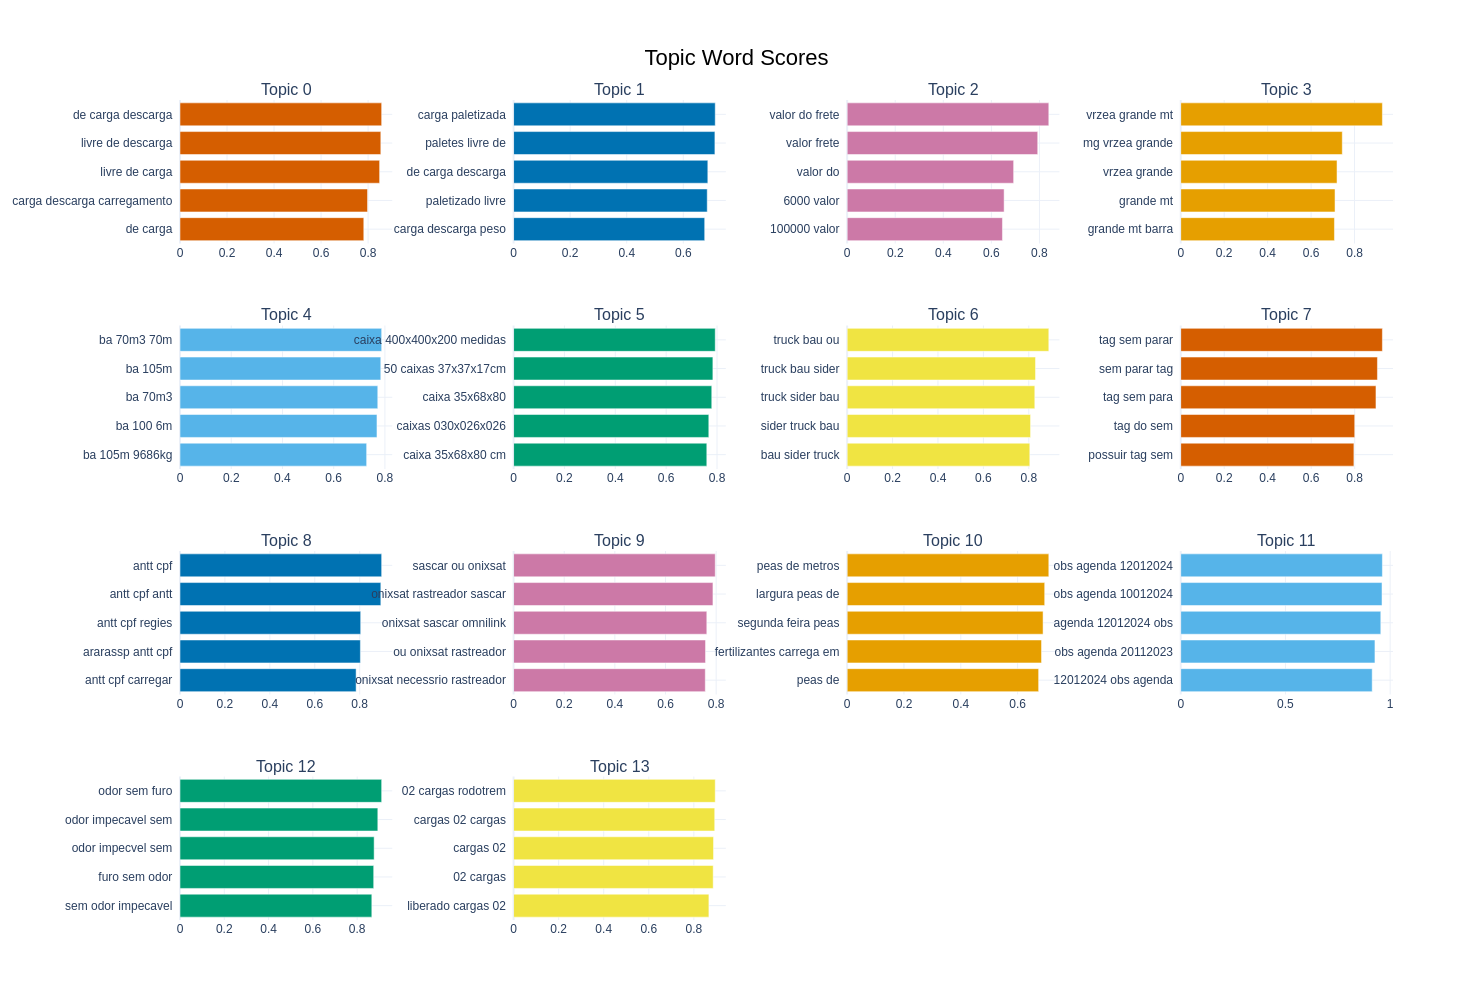

In [99]:
topic_model.visualize_barchart(top_n_topics=20)

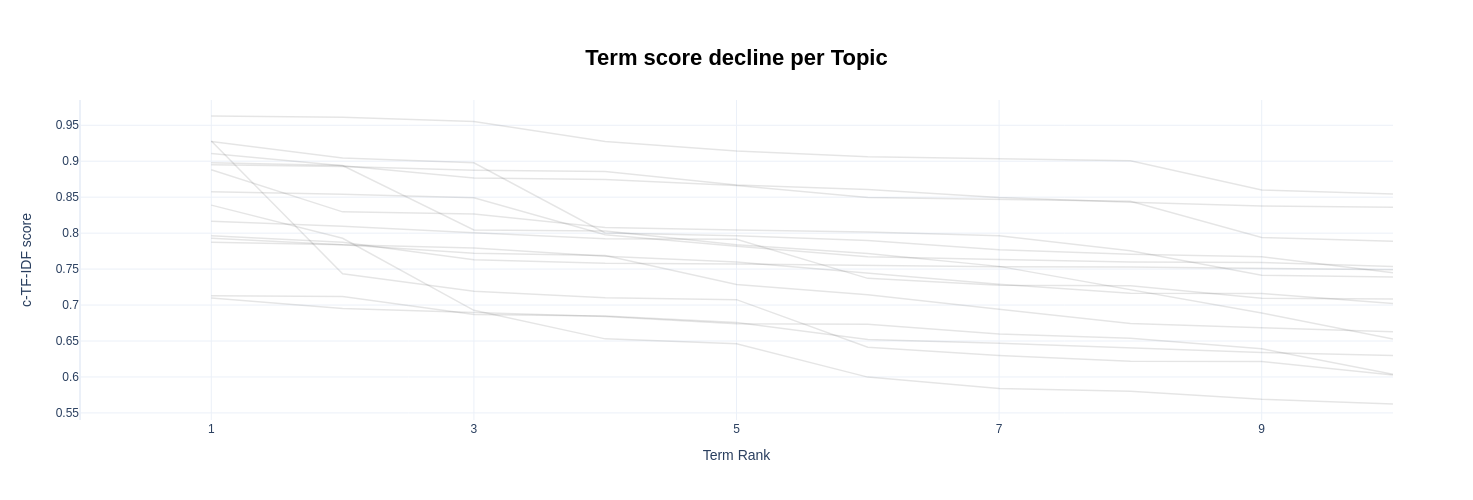

In [101]:
topic_model.visualize_term_rank()

#### Visualizando a distância entre os tópicos

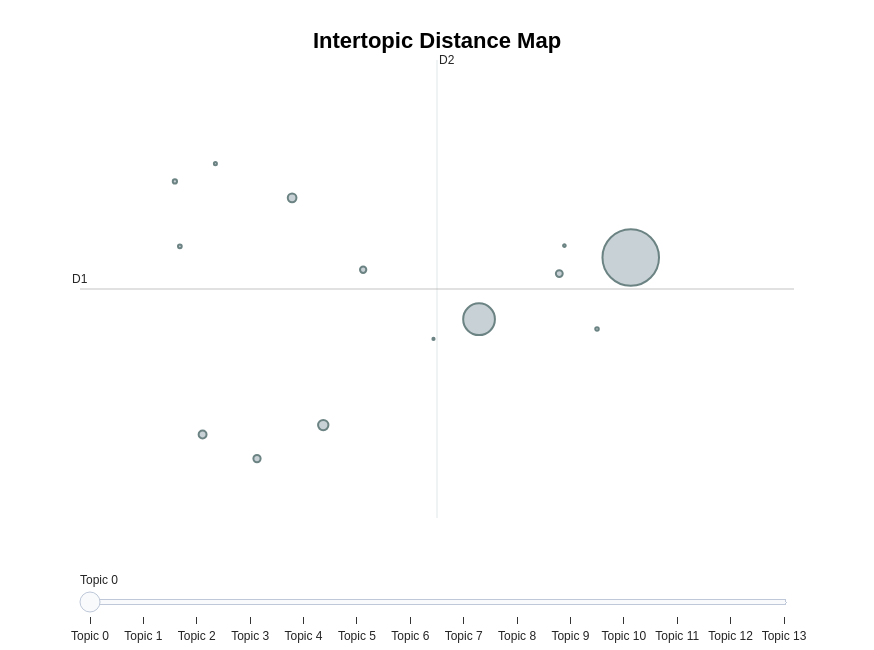

In [100]:
topic_model.visualize_topics()

#### Vizualiando as conexões entre os tópicos

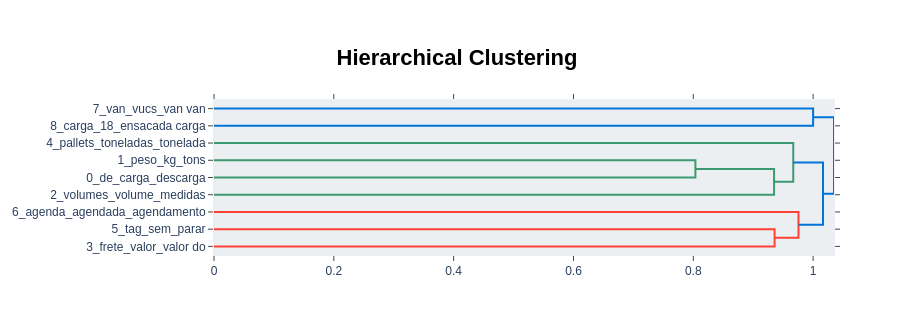

In [49]:
topic_model.visualize_hierarchy(top_n_topics=20)

#### Matrix de similaridade usando heatmap

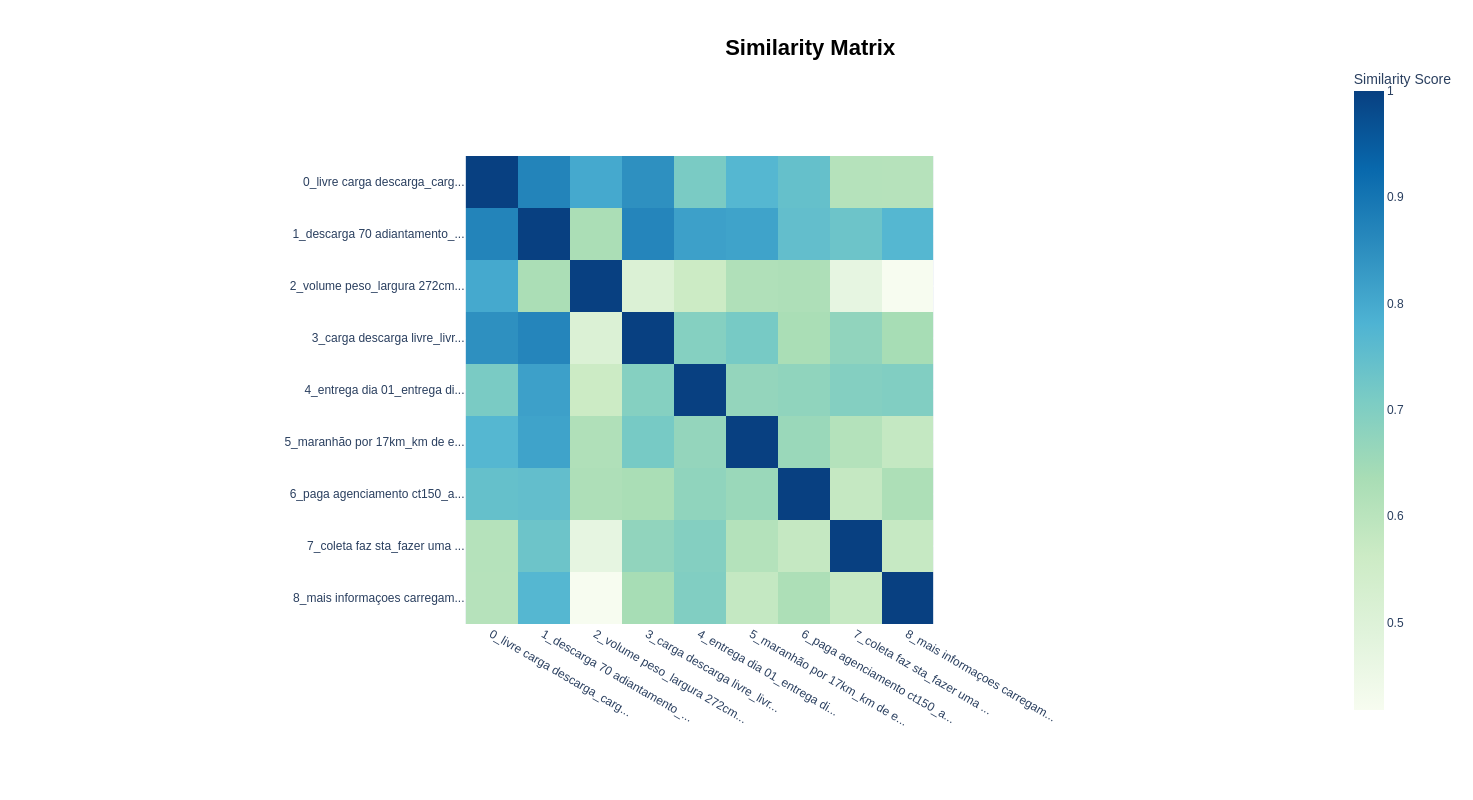

In [86]:
topic_model.visualize_heatmap()

In [65]:
df[df['topics'] == 11]

,ID,DAY_WEEK,OBS,comprimento,topics
93811,44000,2023-11-06/2023-11-12,xxxxxxxxxxxxxx,14,11
93416,43796,2023-11-27/2023-12-03,cch ld,7,11
27070,12619,2023-10-30/2023-11-05,,6,11
73787,34544,2023-12-04/2023-12-10,x,11,11
15383,7240,2023-11-27/2023-12-03,cc,3,11
70143,32823,2024-01-08/2024-01-14,win,3,11
22678,10623,2024-01-22/2024-01-28,x,13,11
21993,10315,2024-01-29/2024-02-04,holambra x tes,14,11
86908,40715,2024-01-22/2024-01-28,cnh com ear,11,11
53944,25228,2023-10-30/2023-11-05,somente cnpj,13,11
